# Climate scenario data

In this notebook we will...
1. ... aggregate and download climate scenario data from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://wcrp-cmip.org/cmip-phase-6-cmip6/)) for our catchment,
2. ... preprocess the data,
3. ... compare the CMIP6 models with our reanalysis data and adjust them for bias,
4. ... and visualize the data before and after bias adjustment.

The [NEX-GDDP-CMIP6 dataset](https://www.nature.com/articles/s41597-022-01393-4) we are going to use has been downscaled to 27830 m resolution by the [NASA Climate Analytics Group](https://www.nature.com/articles/s41597-022-01393-4) and is available in two [Shared Socio-Economic Pathways](https://unfccc.int/sites/default/files/part1_iiasa_rogelj_ssp_poster.pdf) (SSP2 and SSP5). It is available via [Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/NASA_GDDP-CMIP6#bands) which makes it subsettable on the server side and the download relatively light-weight.

We start by importing and initializing the Google Earth Engine packages again.

In [2]:
import ee
import geemap
import numpy as np

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

The next cell reads the output directory location and the catchment outline as target polygon.

In [3]:
import configparser
import ast
import geopandas as gpd

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get paths from config.ini
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
output_gpkg = dir_output + config['FILE_SETTINGS']['GPKG_NAME']

# load catchment outline as target polygon
catchment_new = gpd.read_file(output_gpkg, layer='catchment_new')
catchment = geemap.geopandas_to_ee(catchment_new)

## Select, aggregate, and download downscaled CMIP6 data

We are going to create a class that does it all in one go. The `buildFeauture()` function requests daily catchment-wide averages of all available CMIP6 models for individual years. All years requested are stored in an `ee.ImageCollection` by `getResult()`. To provide the best basis for bias adjustment a large overlap of reanalysis and scenario data is recommended. By default, the `CMIPDownloader` class requests everything between the earliest available date from ERA5-Land (1979) and the latest available date from CMIP6 (2100). The `download()` function then starts a given number of parallel requests, each downloading a single year and storing them in CSV files.


In [6]:
import concurrent.futures
import os
import requests
from retry import retry
from tqdm import tqdm


class CMIPDownloader:
    """Class to download spatially averaged CMIP6 data for a given period, variable, and spatial subset."""

    def __init__(self, var, starty, endy, shape, processes=10, dir='./'):
        self.var = var
        self.starty = starty
        self.endy = endy
        self.shape = shape
        self.processes = processes
        self.directory = dir

        # create the download directory if it doesn't exist
        if not os.path.exists(self.directory):
            os.makedirs(self.directory)

    def download(self):
        """Runs a subset routine for CMIP6 data on GEE servers to create ee.FeatureCollections for all years in
        the requested period. Downloads individual years in parallel processes to increase the download time."""
        
        print('Initiating download request for NEX-GDDP-CMIP6 data from ' +
              str(self.starty) + ' to ' + str(self.endy) + '.')

        def getRequests(starty, endy):
            """Generates a list of years to be downloaded. [Client side]"""

            return [i for i in range(starty, endy+1)]

        @retry(tries=10, delay=1, backoff=2)
        def getResult(index, year):
            """Handle the HTTP requests to download one year of CMIP6 data. [Server side]"""

            start = str(year) + '-01-01'
            end = str(year + 1) + '-01-01'
            startDate = ee.Date(start)
            endDate = ee.Date(end)
            n = endDate.difference(startDate, 'day').subtract(1)

            def getImageCollection(var):
                """Create and image collection of CMIP6 data for the requested variable, period, and region.
                [Server side]"""

                collection = ee.ImageCollection('NASA/GDDP-CMIP6') \
                    .select(var) \
                    .filterDate(startDate, endDate) \
                    .filterBounds(self.shape)
                return collection

            def renameBandName(b):
                """Edit variable names for better readability. [Server side]"""

                split = ee.String(b).split('_')
                return ee.String(split.splice(split.length().subtract(2), 1).join("_"))

            def buildFeature(i):
                """Create an area weighted average of the defined region for every day in the given year.
                [Server side]"""

                t1 = startDate.advance(i, 'day')
                t2 = t1.advance(1, 'day')
                # feature = ee.Feature(point)
                dailyColl = collection.filterDate(t1, t2)
                dailyImg = dailyColl.toBands()
                # renaming and handling names
                bands = dailyImg.bandNames()
                renamed = bands.map(renameBandName)
                # Daily extraction and adding time information
                dict = dailyImg.rename(renamed).reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=self.shape,
                ).combine(
                    ee.Dictionary({'system:time_start': t1.millis(), 'isodate': t1.format('YYYY-MM-dd')})
                )
                return ee.Feature(None, dict)

            # Create features for all days in the respective year. [Server side]
            collection = getImageCollection(self.var)
            year_feature = ee.FeatureCollection(ee.List.sequence(0, n).map(buildFeature))

            # Create a download URL for a CSV containing the feature collection. [Server side]
            url = year_feature.getDownloadURL()

            # Handle downloading the actual csv for one year. [Client side]
            r = requests.get(url, stream=True)
            if r.status_code != 200:
                r.raise_for_status()
            filename = os.path.join(self.directory, 'cmip6_' + self.var + '_' + str(year) + '.csv')
            with open(filename, 'w') as f:
                f.write(r.text)

            return index

        # Create a list of years to be downloaded. [Client side]
        items = getRequests(self.starty, self.endy)

        # Launch download requests in parallel processes and display a status bar. [Client side]
        with tqdm(total=len(items), desc="Downloading CMIP6 data for variable '" + self.var + "'") as pbar:
            results = []
            with concurrent.futures.ThreadPoolExecutor(max_workers=self.processes) as executor:
                for i, year in enumerate(items):
                    results.append(executor.submit(getResult, i, year))
                for future in concurrent.futures.as_completed(results):
                    index = future.result()
                    pbar.update(1)

        print("All downloads complete.")

We can now define a target location and start the download for both desired variables individually. We choose a moderate number of requests to avoid kernel "hickups". The download time depends on the number of parallel processes, the traffic on GEE servers, and other mysterious factors. If you run this notebook in a Binder it usually doesn't take more than 5 min for both downloads to finish.

In [7]:
cmip_dir = dir_output + 'cmip6/'
downloader_t = CMIPDownloader(var='tas', starty=1979, endy=2100, shape=catchment, processes=30, dir=cmip_dir)
downloader_t.download()
downloader_p = CMIPDownloader(var='pr', starty=1979, endy=2100, shape=catchment, processes=30, dir=cmip_dir)
downloader_p.download()

Initiating download request for NEX-GDDP-CMIP6 data from 1979 to 2100.


All downloads complete.
Initiating download request for NEX-GDDP-CMIP6 data from 1979 to 2100.


All downloads complete.


We have now downloaded individual files for each year and variable and stored them in `cmip_dir`. To use them as model forcing data, they need to be processed.

## Process the downloaded CSV files

The following class will read all downloaded CSV files and concatenate them to a single file per scenario. It further checks for consistency and drops models not available for individual years or scenarios.

In [10]:
import pandas as pd

class CMIPProcessor:
    """Class to read and pre-process CSV files downloaded by the CMIPDownloader class."""
    def __init__(self, var, file_dir='.'):
        self.file_dir = file_dir
        self.var = var
        self.df_hist = self.append_df(self.var, self.file_dir, hist=True)
        self.df_ssp = self.append_df(self.var, self.file_dir, hist=False)
        self.ssp2_common, self.ssp5_common, self.hist_common,\
            self.common_models, self.dropped_models = self.process_dataframes()
        self.ssp2, self.ssp5 = self.get_results()

    def read_cmip(self, filename):
        """Reads CMIP6 CSV files and drops redundant columns."""

        df = pd.read_csv(filename, index_col='isodate', parse_dates=['isodate'])
        df = df.drop(['system:index', '.geo', 'system:time_start'], axis=1)
        return df

    def append_df(self, var, file_dir='.', hist=True):
        """Reads CMIP6 CSV files of individual years and concatenates them into dataframes for the full downloaded
        period. Historical and scenario datasets are treated separately. Converts precipitation unit to mm."""

        df_list = []
        if hist:
            starty = 1979
            endy = 2014
        else:
            starty = 2015
            endy = 2100
        for i in range(starty, endy + 1):
            filename = file_dir + 'cmip6_' + var + '_' + str(i) + '.csv'
            df_list.append(self.read_cmip(filename))
        if hist:
            hist_df = pd.concat(df_list)
            if var == 'pr':
                hist_df = hist_df * 86400       # from kg/(m^2*s) to mm/day
            return hist_df
        else:
            ssp_df = pd.concat(df_list)
            if var == 'pr':
                ssp_df = ssp_df * 86400       # from kg/(m^2*s) to mm/day
            return ssp_df

    def process_dataframes(self):
        """Separates the two scenarios and drops models not available for both scenarios and the historical period."""

        ssp2 = self.df_ssp.loc[:, self.df_ssp.columns.str.startswith('ssp245')]
        ssp5 = self.df_ssp.loc[:, self.df_ssp.columns.str.startswith('ssp585')]
        hist = self.df_hist.loc[:, self.df_hist.columns.str.startswith('historical')]

        ssp2.columns = ssp2.columns.str.lstrip('ssp245_').str.rstrip('_' + self.var)
        ssp5.columns = ssp5.columns.str.lstrip('ssp585_').str.rstrip('_' + self.var)
        hist.columns = hist.columns.str.lstrip('historical_').str.rstrip('_' + self.var)

        # Get all the models the three datasets have in common
        common_models = set(ssp2.columns).intersection(ssp5.columns).intersection(hist.columns)

        # Get the model names that contain NaN values
        nan_models_list = [df.columns[df.isna().any()].tolist() for df in [ssp2, ssp5, hist]]
        # flatten the list
        nan_models = [col for sublist in nan_models_list for col in sublist]
        # remove duplicates
        nan_models = list(set(nan_models))

        # Remove models with NaN values from the list of common models
        common_models = [x for x in common_models if x not in nan_models]

        ssp2_common = ssp2.loc[:, common_models]
        ssp5_common = ssp5.loc[:, common_models]
        hist_common = hist.loc[:, common_models]

        dropped_models = list(set([mod for mod in ssp2.columns if mod not in common_models] +
                                  [mod for mod in ssp5.columns if mod not in common_models] +
                                  [mod for mod in hist.columns if mod not in common_models]))

        return ssp2_common, ssp5_common, hist_common, common_models, dropped_models

    def get_results(self):
        """Concatenates historical and scenario data to combined dataframes of the full downloaded period.
        Arranges the models in alphabetical order."""

        ssp2_full = pd.concat([self.hist_common, self.ssp2_common])
        ssp2_full.index.names = ['TIMESTAMP']
        ssp5_full = pd.concat([self.hist_common, self.ssp5_common])
        ssp5_full.index.names = ['TIMESTAMP']

        ssp2_full = ssp2_full.reindex(sorted(ssp2_full.columns), axis=1)
        ssp5_full = ssp5_full.reindex(sorted(ssp5_full.columns), axis=1)


        return ssp2_full, ssp5_full

The `CMIPProcessor` processes variables individually and returns a single dataframe for each of both scenarios from 1979 to 2100.

In [11]:
processor_t = CMIPProcessor(file_dir=cmip_dir, var='tas')
ssp2_tas_raw, ssp5_tas_raw = processor_t.get_results()

processor_p = CMIPProcessor(file_dir=cmip_dir, var='pr')
ssp2_pr_raw, ssp5_pr_raw = processor_p.get_results()

Let's have a look. We can see that our scenario dataset now contains 33 CMIP6 models in alphabetical order.

In [13]:
print(ssp2_tas_raw.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44560 entries, 1979-01-01 to 2100-12-31
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ACCESS-CM2        44560 non-null  float64
 1   ACCESS-ESM1-5     44560 non-null  float64
 2   BCC-CSM2-MR       44560 non-null  float64
 3   CESM2             44560 non-null  float64
 4   CESM2-WACCM       44560 non-null  float64
 5   CMCC-CM2-SR5      44560 non-null  float64
 6   CMCC-ESM2         44560 non-null  float64
 7   CNRM-CM6-1        44560 non-null  float64
 8   CNRM-ESM2-1       44560 non-null  float64
 9   CanESM5           44560 non-null  float64
 10  EC-Earth3         44560 non-null  float64
 11  EC-Earth3-Veg-LR  44560 non-null  float64
 12  FGOALS-g3         44560 non-null  float64
 13  GFDL-CM4_gr1      44560 non-null  float64
 14  GFDL-CM4_gr2      44560 non-null  float64
 15  GFDL-ESM4         44560 non-null  float64
 16  GISS-E2-1-G       44560

If we want to check which models failed the consistency check of the `CMIPProcessor` we can use its `dropped_models` attribute.

In [14]:
print(processor_t.dropped_models)

['IITM-ESM', 'GFDL-CM4', 'HadGEM3-GC31-MM']


## Bias adjustment using reananlysis data

Due to the coarse resolution of global climate models (GCMs) and the extensive correction of reanalysis data there is substantial bias between the two datasets. To force a glacio-hydrological model calibrated on reanalysis data with climate scenarios this bias needs to be adressed. We will use a method developed by [Switanek et.al. (2017)](https://doi.org/10.5194/hess-21-2649-2017) called Scaled Distribution Mapping (SDM) to correct for bias while preserving trends and the likelihood of meteorological events in the raw GCM data. The method has been implemented in the [`bias_correction`](https://github.com/pankajkarman/bias_correction) Python library by [Pankaj Kumar](https://pankajkarman.github.io/).
We will first create a function to read our reanalysis CSV. The `adjust_bias()` function will then loop over all models and adjust them to the reanalysis data in the overlap period (1979 to 2022).

In [16]:
from bias_correction import BiasCorrection

def read_era5l(file):
    """Reads ERA5-Land data, drops redundant columns, and adds DatetimeIndex.
    Resamples the dataframe to reduce the DatetimeIndex to daily resolution."""
    
    return pd.read_csv(file, **{
        'usecols':      ['temp', 'prec', 'dt'],
        'index_col':    'dt',
        'parse_dates':  ['dt']}).resample('D').agg({'temp': 'mean', 'prec': 'sum'})

def adjust_bias(predictand, predictor, method='normal_mapping'):
    """Applies scaled distribution mapping to all passed climate projections (predictand)
     based on a predictor timeseries."""
    
    predictor = read_era5l(predictor)
    if predictand.mean().mean() > 100:
        var = 'temp'
    else:
        var = 'prec'
    training_period = slice('1979-01-01', '2022-12-31')
    prediction_period = slice('1979-01-01', '2100-12-31')
    corr = pd.DataFrame()
    for m in predictand.columns:
        x_train = predictand[m][training_period].squeeze()
        y_train = predictor[training_period][var].squeeze()
        x_predict = predictand[m][prediction_period].squeeze()
        bc_corr = BiasCorrection(y_train, x_train, x_predict)
        corr[m] = pd.DataFrame(bc_corr.correct(method=method))

    return corr

The function is applied to every variable and scenario separately.

In [17]:
era5_file = dir_output + 'ERA5L.csv'

ssp2_tas = adjust_bias(predictand=ssp2_tas_raw, predictor=era5_file)
ssp5_tas = adjust_bias(predictand=ssp5_tas_raw, predictor=era5_file)
ssp2_pr = adjust_bias(predictand=ssp2_pr_raw, predictor=era5_file)
ssp5_pr = adjust_bias(predictand=ssp5_pr_raw, predictor=era5_file)

The result is a comprehensive dataset of 33 models over 122 years in two versions (pre- and post-adjustment) for every variable. To see what's in the data and what happened during bias adjustment we need an overview.

## 	Visualization

First, we store our raw and adjusted data in dictionaries.

In [18]:
ssp_tas_dict = {'SSP2_raw': ssp2_tas_raw, 'SSP2_adjusted': ssp2_tas, 'SSP5_raw': ssp5_tas_raw, 'SSP5_adjusted': ssp5_tas}
ssp_pr_dict = {'SSP2_raw': ssp2_pr_raw, 'SSP2_adjusted': ssp2_pr, 'SSP5_raw': ssp5_pr_raw, 'SSP5_adjusted': ssp5_pr}

The first plot will contain simple timeseries. The first function `cmip_plot()` resamples the data so a given frequency and creates a single plot. `cmip_plot_combined()` arranges multiple plots for both scenarios before and after bias adjustment.

In [21]:
import matplotlib.pyplot as plt

def cmip_plot(ax, df, title, target, precip=False, intv_sum='M', intv_mean='10Y',
              target_label='Target', show_target_label=False):
    """Resamples and plots climate model and target data."""
    
    if not precip:
        ax.plot(df.resample(intv_mean).mean().iloc[:, :-1], linewidth=0.6)
        ax.plot(df.resample(intv_mean).mean().iloc[:, -1], linewidth=1, c='black')
        era_plot, = ax.plot(target['temp'].resample(intv_mean).mean(), linewidth=1.5, c='red', label=target_label,
                            linestyle='dashed')
    else:
        ax.plot(df.resample(intv_sum).sum().resample(intv_mean).mean().iloc[:, :-1],
                linewidth=0.6)
        ax.plot(df.resample(intv_sum).sum().resample(intv_mean).mean().iloc[:, -1],
                linewidth=1, c='black')
        era_plot, = ax.plot(target['prec'].resample(intv_sum).sum().resample(intv_mean).mean(), linewidth=1.5,
                            c='red', label=target_label, linestyle='dashed')
    if show_target_label:
        ax.legend(handles=[era_plot], loc='upper left')
    ax.set_title(title)
    ax.grid(True)
    

def cmip_plot_combined(data, target, title, precip=False, intv_sum='M', intv_mean='10Y',
                       target_label='Target', show=False):
    """Combines multiple subplots of climate data in different scenarios before and after bias adjustment.
    Shows target data for comparison"""

    figure, axis = plt.subplots(2, 2, figsize=(12, 12), sharex="col", sharey="all")
    
    t_kwargs = {'target': target, 'intv_mean': intv_mean, 'target_label': target_label}
    p_kwargs = {'target': target, 'intv_mean': intv_mean, 'target_label': target_label,
                'intv_sum': intv_sum, 'precip': True}

    if not precip:
        cmip_plot(axis[0, 0], data['SSP2_raw'], show_target_label=True, title='SSP2 raw', **t_kwargs)
        cmip_plot(axis[0, 1], data['SSP2_adjusted'], title='SSP2 adjusted', **t_kwargs)
        cmip_plot(axis[1, 0], data['SSP5_raw'], title='SSP5 raw', **t_kwargs)
        cmip_plot(axis[1, 1], data['SSP5_adjusted'], title='SSP5 adjusted', **t_kwargs)
        figure.legend(data['SSP5_adjusted'].columns, loc='lower right', ncol=6, mode="expand")
        figure.tight_layout()
        figure.subplots_adjust(bottom=0.15, top=0.92)
        figure.suptitle(title, fontweight='bold')
        if show:
            plt.show()
    else:
        cmip_plot(axis[0, 0], data['SSP2_raw'], show_target_label=True, title='SSP2 raw', **p_kwargs)
        cmip_plot(axis[0, 1], data['SSP2_adjusted'], title='SSP2 adjusted', **p_kwargs)
        cmip_plot(axis[1, 0], data['SSP5_raw'], title='SSP5 raw', **p_kwargs)
        cmip_plot(axis[1, 1], data['SSP5_adjusted'], title='SSP5 adjusted', **p_kwargs)
        figure.legend(data['SSP5_adjusted'].columns, loc='lower right', ncol=6, mode="expand")
        figure.tight_layout()
        figure.subplots_adjust(bottom=0.15, top=0.92)
        figure.suptitle(title, fontweight='bold')
        if show:
            plt.show()

By default temperature data is resampled to 10y means, precipitation data is shown in 10y means of monthly sums.

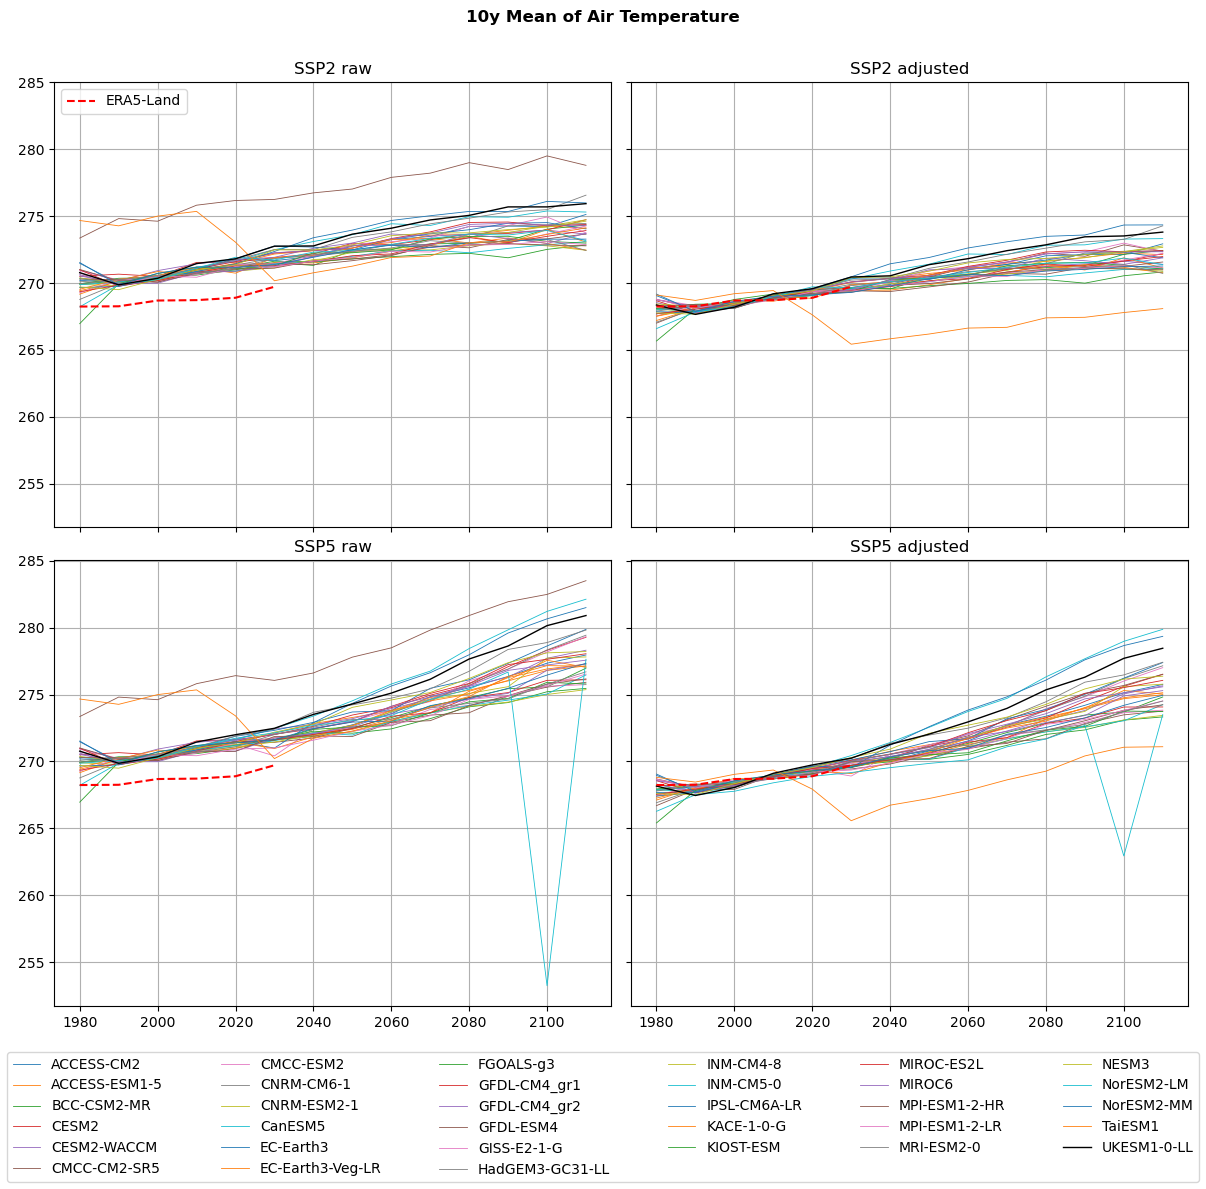

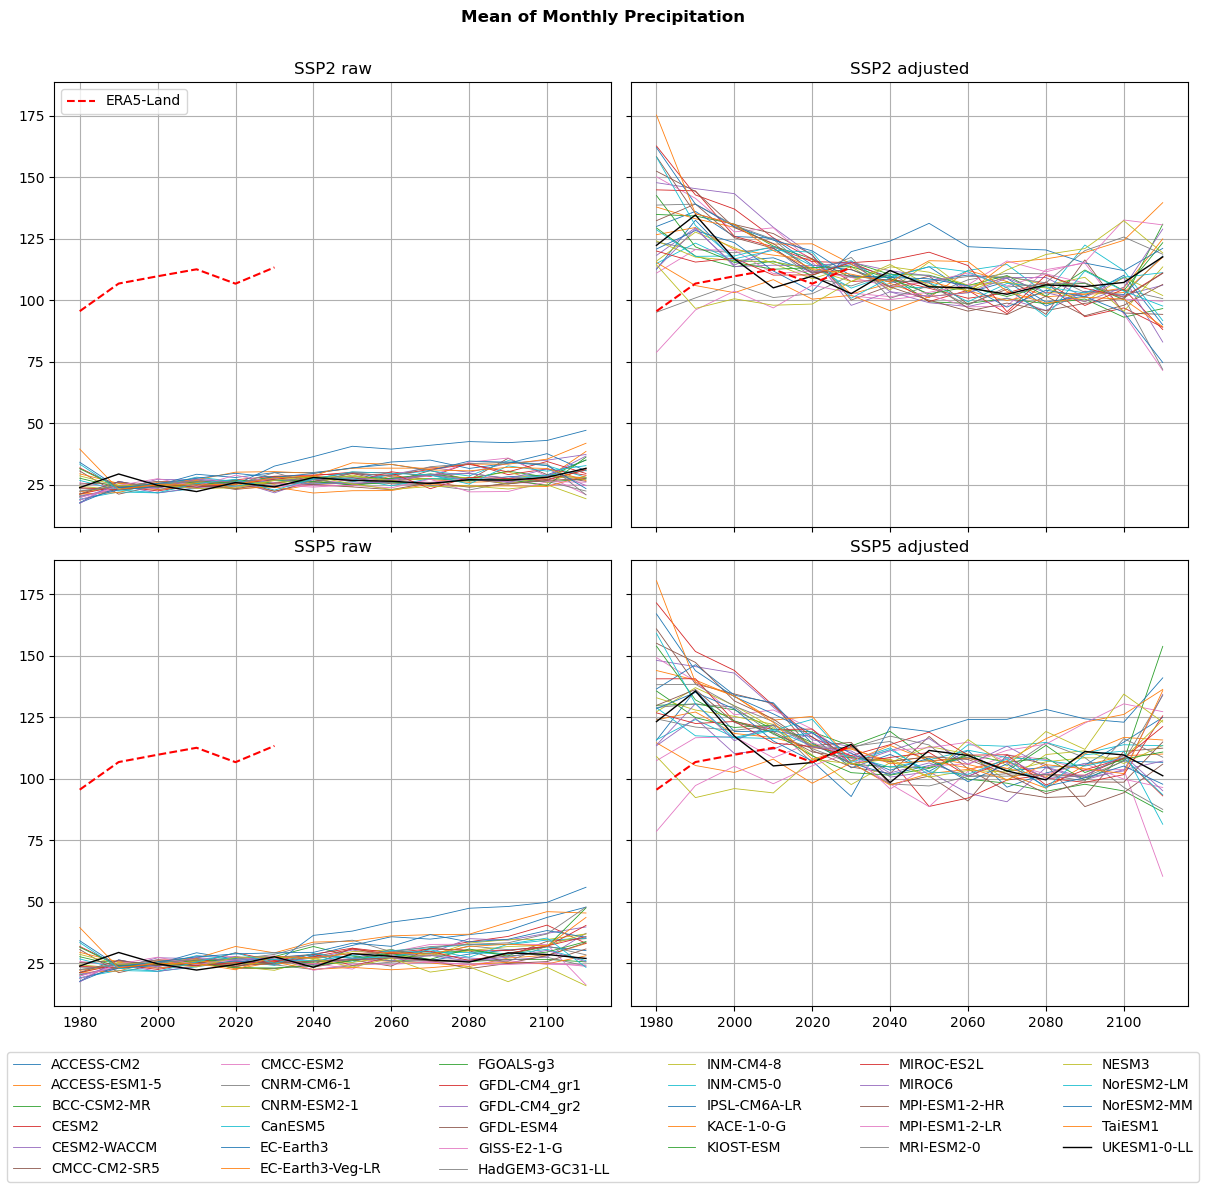

In [22]:
era5 = read_era5l(era5_file)

cmip_plot_combined(data=ssp_tas_dict, target=era5, title='10y Mean of Air Temperature', target_label='ERA5-Land', show=True)
cmip_plot_combined(data=ssp_pr_dict, target=era5, title='Mean of Monthly Precipitation', precip=True, target_label='ERA5-Land', show=True)